In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()
sns.set_context('notebook')
sns.set_palette('viridis')

In [3]:
hous_df = pd.read_csv('Ames_Housing_Price_Data.csv', 
                      index_col='PID', low_memory=False)

In [4]:
## There is a duplicated record.
hous_df = hous_df.drop_duplicates()

In [6]:
## Lose the phony index column (that supposedly differentiates between kaggle/non-kaggle training data).
hous_df = hous_df.drop('Unnamed: 0', axis=1)

In [8]:
## let's use a new sequential index.
hous_df.reset_index(inplace=True)

In [10]:
hous_df.loc[:,'LogSalePrice'] = np.log(hous_df.loc[:,'SalePrice'])

In [12]:
## We know Landmrk has only one property.
hous_no_Landmrk = hous_df.loc[hous_df['Neighborhood']!='Landmrk', :]

In [13]:
## The missing index causes problems for the stratified sampling.
hous_no_Landmrk.reset_index(inplace=True, drop=True)

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

In [15]:
_ = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
split = _.split(X=hous_no_Landmrk, y=np.array(hous_no_Landmrk['LogSalePrice'], hous_no_Landmrk['Neighborhood']))

In [16]:
## This first attempt at a multivar split has problems.
for train_index, test_index in split:
    hous_train = hous_no_Landmrk.loc[train_index].reset_index(drop=True)
    hous_test = hous_no_Landmrk.loc[test_index].reset_index(drop=True)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [17]:
## Curious to see how it handles a split on two variables with no smallness problem.
_ = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
split = _.split(X=hous_df, y=np.array(hous_df['LogSalePrice'], hous_df['GrLivArea']))

In [18]:
## Seems at least one of the problems is you need to bin continuous variables.
for train_index, test_index in split:
    hous_train = hous_df.loc[train_index].reset_index(drop=True)
    hous_test = hous_df.loc[test_index].reset_index(drop=True)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [52]:
hous_df.loc[:,'LogSP_Bin'] = pd.cut(hous_df.loc[:,'LogSalePrice'], bins=4).astype('string')

In [53]:
hous_df.loc[:,'Sqft_Bin'] = pd.cut(hous_df.loc[:,'GrLivArea'], bins=4).astype('string')

In [54]:
## Using number of bins rather than bin edges it is hard to avoid having
## at least one pairing with only one property.
hous_df.groupby(['LogSP_Bin', 'Sqft_Bin']).count().sort_values('PID')['PID']

LogSP_Bin         Sqft_Bin         
(11.495, 12.515]  (3590.5, 4676.0]        1
(12.515, 13.534]  (329.658, 1419.5]       3
(9.452, 10.476]   (329.658, 1419.5]       4
(12.515, 13.534]  (3590.5, 4676.0]        5
(10.476, 11.495]  (1419.5, 2505.0]       13
(11.495, 12.515]  (2505.0, 3590.5]       33
(12.515, 13.534]  (2505.0, 3590.5]       57
(10.476, 11.495]  (329.658, 1419.5]     163
(12.515, 13.534]  (1419.5, 2505.0]      193
(11.495, 12.515]  (1419.5, 2505.0]     1029
                  (329.658, 1419.5]    1079
Name: PID, dtype: int64

In [58]:
## Partial!!
hous_df[hous_df['GrLivArea']==hous_df.max()['GrLivArea']]

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LogSalePrice,LogSP_Bin,Sqft_Bin
309,908154205,4676,184750,60,RL,130.0,40094,Pave,NaN,IR1,...,NaN,NaN,0,10,2007,New,Partial,12.126759,"(11.495, 12.515]","(3590.5, 4676.0]"


In [31]:
## Try again using the bins.
_ = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
split = _.split(X=hous_df, y=hous_df.loc[:,['LogSP_Bin', 'Sqft_Bin']])

In [32]:
## Abandone for now due to loss of patience. Return to identify bin edges if necessary.
for train_index, test_index in split:
    hous_train = hous_df.loc[train_index].reset_index(drop=True)
    hous_test = hous_df.loc[test_index].reset_index(drop=True)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

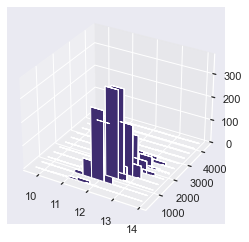

In [34]:
# This is from an example found online, I haven't taken the time to understand the different bits.

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x, y = hous_df['LogSalePrice'], hous_df['GrLivArea']
hist, xedges, yedges = np.histogram2d(x, y, bins=12)

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()